In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from   scipy.interpolate import splrep, splev
import scipy
from matplotlib import gridspec


In [17]:
class HullWhite():
    def __init__(self, times, yield_curve, alpha, sigma, r0 = None):

        self.dt = 0.00001
        self.times = times
        self.a = alpha
        self.sigma = sigma
        if not r0:
            self.r0 = yield_curve.iloc[0]
        else:
            self.r0 = r0
        self.yieldCurve = splrep(times, yield_curve) #create a spline representation of the yield curve
    
        self.spline_theta()


    def y(self, t):
        '''
        Returns y(t) using the spline reperesntation
        '''
        return splev(t, self.yieldCurve)

    def dydt(self, t):
        '''
        returns dy/dt using the spline representation
        '''
        return splev(t, self.yieldCurve, der = 1)


    def forward_rate(self, t):
        '''
        returns the forward rate, i.e f(0,T), as a function of the yield-curve 
        '''
        return self.y(t) + t * self.dydt(t)

    def theta(self, t):
        '''
        calculates theta for a given T
        '''
        dfdt = self.forward_rate(max(t + self.dt, 0)) - self.forward_rate(max(t-self.dt, 0))
        dfdt /= (2*self.dt)

        return dfdt + self.a * self.forward_rate(t) + (self.sigma**2)/(self.a*2)*(1-np.exp(-2*self.a*t))

    def spline_theta(self):
        '''
        Create a spline representation of theta
        '''
        times = np.linspace(self.times.iloc[0], self.times.iloc[-1], 1000)
        thetas = [self.theta(t) for t in times]
        self.theta_splrep = splrep(times, thetas)

    def eval_theta(self, x):
        '''
        method for evaluating the spline reprsentation of theta(t), returns theta(t)
        '''
        return splev(x, self.theta_splrep)

    def A(self, t, T):
        '''
        A(t,T)
        '''
        def int1(x):
            theta = splev(x, self.theta_splrep)
            return theta * self.B(x,T)
        def int2(x):
            return self.B(x, T)**2
        
        eval1 = scipy.integrate.quad(int1, t, T)[0]
        eval2 = scipy.integrate.quad(int2, t, T)[0]

        return -eval1 + 0.5*(self.sigma**2)*eval2

    def B(self, t, T):
        '''
        B(t,T)
        '''
        return (1/self.a) * (1-np.exp(-self.a*(T-t)))
    
    def simple_zcb(self, T):
        B = self.B(0, T)
        A = self.A(0, T)
        return np.exp(A-self.r0*B)

    def simulate_paths(self, number_of_steps, number_of_simulations, T):
        dt = T/float(number_of_steps)

        xh = np.zeros((number_of_steps+ 1, number_of_simulations))
        self.rates = np.zeros_like(xh)
        self.rates_times = np.linspace(0, T, number_of_steps + 1)

        xh[0] = self.r0

        for i in range(1, number_of_steps + 1):
            xh[i] = xh[i-1] + (self.theta(self.rates_times[i-1]) - self.a * xh[i-1]) * dt \
                             + self.sigma * np.sqrt(dt) * np.random.standard_normal(number_of_simulations)
        self.rates = xh


    def price_zcb_using_rates(self, t, T):
        '''
        Uses simulated rates to calculate p(t,T)
        '''
        times  = self.rates_times
        dt = times[1] - times[0] 

        idx = np.where((times < T) & (times > t ))[0]
        rates = self.rates[idx,:]

        mean_p_t_T = np.exp(- rates.sum(axis = 0) * dt).mean()
        std_p_t_T = np.exp(- rates.sum(axis = 0) * dt).std()

        return mean_p_t_T, std_p_t_T

    def price_zbp(self, Tf , Tp, K):
        sigma = self.sigma 
        a = self.a
        var = sigma**2 / (2*a**3) * (1- np.exp(-2*a * Tf)) * (1 - np.exp(-a * (Tp - Tf)) )**2

        p0Tf, _  = self.price_zcb_using_rates(0, Tf)
        p0Tp, _  = self.price_zcb_using_rates(0, Tp)

        #print(p0Tf)
        #print(p0Tp)

        dplus =  (np.log(K*p0Tf/p0Tp) + 1/2*var) / np.sqrt(var)
        dminus = (np.log(K*p0Tf/p0Tp) - 1/2*var) / np.sqrt(var)

        return K * p0Tp * scipy.stats.norm.cdf(dplus) - p0Tp * scipy.stats.norm.cdf(dminus)

    
    def price_caplet(self, Tf, Tp, K):
        delta = (Tp - Tf) 

        return (1+K*delta) * self.price_zbp(Tf, Tp, 1/(1+ K * delta))  


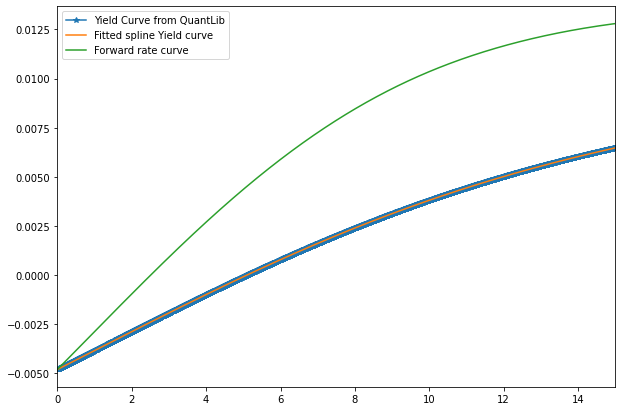

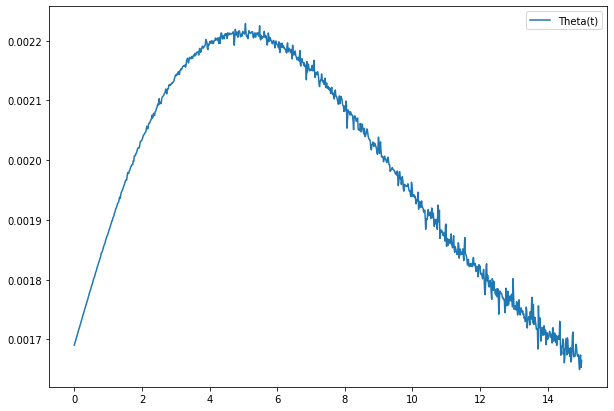

In [18]:
a = 0.05
sigma = 0.01

data = pd.read_excel("curve.xlsx")
data['Curve'] /= 100

data.dropna(inplace = True)



#create an instance of the hull-white model
hw = HullWhite(data['T'], data['Curve'], alpha = 0.05, sigma = 0.01)

x = np.linspace(0, 15, 1000)

#=============================================
# Code to plot yield curve & forward curve
#=============================================
fig, axs = plt.subplots(1,1, figsize = (10, 7))
axs.plot(data['T'], data['Curve'], '-*')
axs.plot(x, [hw.y(t) for t in x])
axs.plot(x, [hw.forward_rate(t) for t in x])
axs.legend(['Yield Curve from QuantLib', 'Fitted spline Yield curve', 'Forward rate curve'])
axs.set_xlim(0,15)
fig.savefig("forward_curve.png")

#============================================
# Code to plot the fitted theta
#============================================
fig, axs = plt.subplots(1,1, figsize = (10 ,7))
axs.plot(x, [hw.eval_theta(t) for t in x])
axs.legend(["Theta(t)"])
fig.savefig("theta.png")

<ipython-input-18-fc462ffe9c85>:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eval1 = scipy.integrate.quad(int1, t, T)[0]
<ipython-input-18-fc462ffe9c85>:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-pur

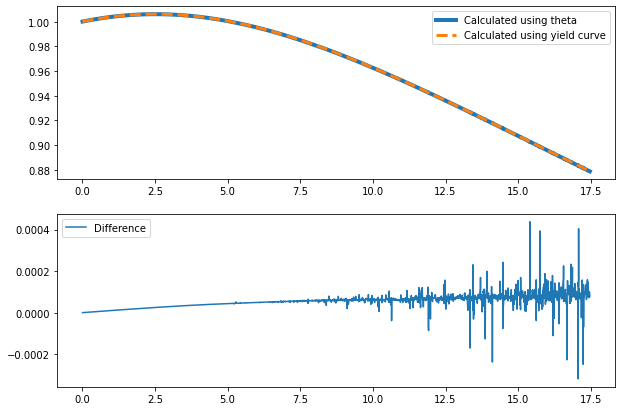

In [21]:
#===============================================================================================
# Code to plot p(0,T) using the fitted thetas vs calculating it with the yield curve
#===============================================================================================
fig, axs = plt.subplots(2,1, figsize = (10, 7))
x = hw.times
axs[0].plot(x, [hw.simple_zcb(t) for t in x], linewidth = 4)
axs[0].plot(data['T'], np.exp(-data['T'] * data['Curve']), '--', linewidth = 3)
axs[1].plot(data['T'],  np.exp(-data['T'] * data['Curve']) - np.array([hw.simple_zcb(t) for t in data['T']]) )
axs[0].legend(["Calculated using theta", "Calculated using yield curve"])
axs[1].legend(["Difference"])
fig.savefig("diff.png")

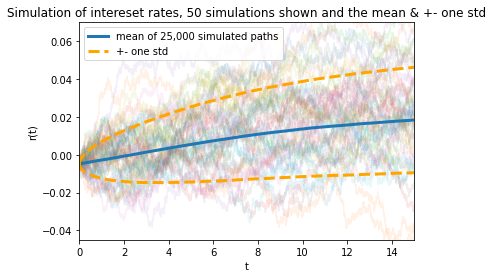

In [19]:
#============================================================
# code to simulate & plot paths of the short-rate
#============================================================
hw.simulate_paths(number_of_steps = 15*365, number_of_simulations = 25000, T = 15)

mean_simulated_rate = np.mean(hw.rates, axis = 1)
std_simulated_rate = np.std(hw.rates, axis = 1)

fig, ax = plt.subplots(1,1)

for i in range(min(hw.rates.shape[1], 50 )):
    ax.plot(hw.rates_times, hw.rates[:,i], alpha = 0.1)

ax.plot(hw.rates_times, mean_simulated_rate, linewidth = 3, label = 'mean of 25,000 simulated paths')
ax.plot(hw.rates_times, mean_simulated_rate - std_simulated_rate,  '--', c = 'orange', linewidth = 3, label = "+- one std")
ax.plot(hw.rates_times, mean_simulated_rate + std_simulated_rate,  '--', c = 'orange', linewidth = 3)

ax.set_ylim(-0.045, 0.07)
ax.set_xlim(0, 15)
ax.legend()

ax.set_title("Simulation of intereset rates, 50 simulations shown and the mean & +- one std")
ax.set_ylabel("r(t)")
ax.set_xlabel("t")

plt.savefig("simulated_interest_rates.png")

<ipython-input-71-9f811a832aeb>:69: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eval1 = scipy.integrate.quad(int1, t, T)[0]
<ipython-input-71-9f811a832aeb>:69: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-pur

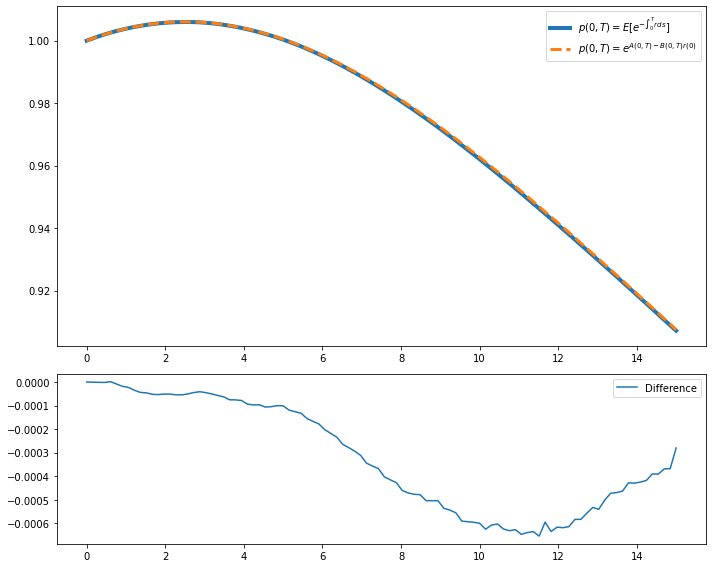

In [74]:
#=====================================================
# Code to plot p(0,T) calculated using simulated rates
#=====================================================
x = np.linspace(0, 15, 100)
ps = []
stds = []

for T in x:
    p, std = hw.price_zcb_using_rates(0, T)
    ps.append(p)
    stds.append(std)

ps = np.array(ps)
stds = np.array(stds)



fig = plt.figure(figsize=(10, 8)) 
gs = gridspec.GridSpec(2, 1, height_ratios=  [2, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, ps, linewidth = 4, label=r'$p(0,T) = E[e^{-\int_0^T{rds}}]$')
ax0.plot(x, [hw.simple_zcb(t) for t in x],'--' , linewidth = 3, label=r'$p(0,T) = e^{A(0,T) - B(0,T)r(0)}$')
ax0.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(x, ps - np.array([hw.simple_zcb(t) for t in x]), label = 'Difference')
ax1.legend()
plt.tight_layout()

fig.savefig("using_rates.png")

Text(0.5, 1.0, '$T_f = 1, T_p = 2$')

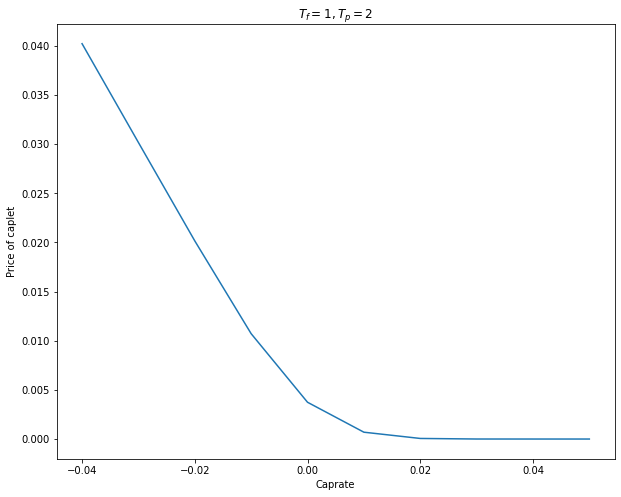

In [37]:
#===========================================================================
# Code to plot the price of a caplet with varying caprate
##==========================================================================

fig, ax = plt.subplots(1,1, figsize = (10,8))

R = np.linspace(-.04, 0.05, 10)

Tf = 1
Tp = 2

prices = [hw.price_caplet(Tf, Tp, r) for r in R]
ax.plot(R,prices)

ax.set_xlabel("Caprate")
ax.set_ylabel("Price of caplet")
ax.set_title(r"$T_f = 1, T_p = 2$")